In [3]:
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


2.10.1


In [2]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5095047678672255359
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15943020618301657464
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [5]:
#Build model

model = Sequential() #0

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

#make four more identical models
model2 = keras.models.clone_model(model) #1
model3 = keras.models.clone_model(model) #2
model4 = keras.models.clone_model(model) #3
model5 = keras.models.clone_model(model) #5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

In [6]:
#Compile the model wiht two staged label smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
#Train the models
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

#one hot labels
y_train_1hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_1hot = tf.keras.utils.to_categorical(y_test, 10)
#two stage label smoothing on model 2 with first epoch with label smoothing and the rest without LS
model2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history2 = model2.fit(x_train, y_train_1hot, epochs=1, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
model2.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
#concatenate to history2
history2_2 = model2.fit(x_train, y_train_1hot, epochs=9, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
#concatenate history2 and history2_2
history2.history['loss'] += history2_2.history['loss']
history2.history['accuracy'] += history2_2.history['accuracy']
history2.history['val_loss'] += history2_2.history['val_loss']
history2.history['val_accuracy'] += history2_2.history['val_accuracy']
history2.history['top_k_categorical_accuracy'] += history2_2.history['top_k_categorical_accuracy']
history2.history['val_top_k_categorical_accuracy'] += history2_2.history['val_top_k_categorical_accuracy']

#two stage label smoothing on model 3 with first epoch with label smoothing and the rest without LS
model3.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history3 = model3.fit(x_train, y_train_1hot, epochs=2, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
model3.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history3_3 = model3.fit(x_train, y_train_1hot, epochs=8, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history3.history['loss'] += history3_3.history['loss']
history3.history['accuracy'] += history3_3.history['accuracy']
history3.history['val_loss'] += history3_3.history['val_loss']
history3.history['val_accuracy'] += history3_3.history['val_accuracy']
history3.history['top_k_categorical_accuracy'] += history3_3.history['top_k_categorical_accuracy']
history3.history['val_top_k_categorical_accuracy'] += history3_3.history['val_top_k_categorical_accuracy']


#two stage label smoothing on model 4 with first epoch with label smoothing and the rest without LS
model4.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history4 = model4.fit(x_train, y_train_1hot, epochs=3, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
model4.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history4_2 = model4.fit(x_train, y_train_1hot, epochs=7, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history4.history['loss'] += history4_2.history['loss']
history4.history['accuracy'] += history4_2.history['accuracy']
history4.history['val_loss'] += history4_2.history['val_loss']
history4.history['val_accuracy'] += history4_2.history['val_accuracy']
history4.history['top_k_categorical_accuracy'] += history4_2.history['top_k_categorical_accuracy']
history4.history['val_top_k_categorical_accuracy'] += history4_2.history['val_top_k_categorical_accuracy']

#two stage label smoothing on model 5 with first epoch with label smoothing and the rest without LS
model5.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history5 = model5.fit(x_train, y_train_1hot, epochs=5, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
model5.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history5_2 = model5.fit(x_train, y_train_1hot, epochs=5, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history5.history['loss'] += history5_2.history['loss']
history5.history['accuracy'] += history5_2.history['accuracy']
history5.history['val_loss'] += history5_2.history['val_loss']
history5.history['val_accuracy'] += history5_2.history['val_accuracy']
history5.history['top_k_categorical_accuracy'] += history5_2.history['top_k_categorical_accuracy']
history5.history['val_top_k_categorical_accuracy'] += history5_2.history['val_top_k_categorical_accuracy']

Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 1.5540 - accuracy: 0.4131 - top_k_categorical_accuracy: 0.2950 - val_loss: 1.1378 - val_accuracy: 0.6001 - val_top_k_categorical_accuracy: 0.3181
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9729 - accuracy: 0.6555 - top_k_categorical_accuracy: 0.3463 - val_loss: 0.8974 - val_accuracy: 0.6884 - val_top_k_categorical_accuracy: 0.2533
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7692 - accuracy: 0.7300 - top_k_categorical_accuracy: 0.3434 - val_loss: 0.7833 - val_accuracy: 0.7275 - val_top_k_categorical_accuracy: 0.3746
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6504 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.3376 - val_loss: 0.7607 - val_accuracy: 0.7442 - val_top_k_categorical_accuracy: 0.2708
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5610 - accuracy: 0.8051 - to

In [7]:
#create a folder to save all these files
import os
if not os.path.exists('cifar10_cnn'):
    os.makedirs('cifar10_cnn')


#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
model2.save('cifar10_cnn2.h5')
model3.save('cifar10_cnn3.h5')
model4.save('cifar10_cnn4.h5')
model5.save('cifar10_cnn5.h5')

#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights.h5')
model2.save_weights('cifar10_cnn2_weights.h5')
model3.save_weights('cifar10_cnn3_weights.h5')
model4.save_weights('cifar10_cnn4_weights.h5')
model5.save_weights('cifar10_cnn5_weights.h5')

#save the histories (loss)
np.save('cifar10_cnn/loss_1.npy', history.history['loss'])
np.save('cifar10_cnn/val_loss_1.npy', history.history['val_loss'])
np.save('cifar10_cnn/top_k_categorical_accuracy_1.npy', history.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/val_top_k_categorical_accuracy_1.npy', history.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/loss_2.npy', history2.history['loss'])
np.save('cifar10_cnn/val_loss_2.npy', history2.history['val_loss'])
np.save('cifar10_cnn/top_k_categorical_accuracy_2.npy', history2.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/val_top_k_categorical_accuracy_2.npy', history2.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/loss_3.npy', history3.history['loss'])
np.save('cifar10_cnn/val_loss_3.npy', history3.history['val_loss'])
np.save('cifar10_cnn/top_k_categorical_accuracy_3.npy', history3.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/val_top_k_categorical_accuracy_3.npy', history3.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/loss_4.npy', history4.history['loss'])
np.save('cifar10_cnn/val_loss_4.npy', history4.history['val_loss'])
np.save('cifar10_cnn/top_k_categorical_accuracy_4.npy', history4.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/val_top_k_categorical_accuracy_4.npy', history4.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/loss_5.npy', history5.history['loss'])
np.save('cifar10_cnn/val_loss_5.npy', history5.history['val_loss'])
np.save('cifar10_cnn/top_k_categorical_accuracy_5.npy', history5.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/val_top_k_categorical_accuracy_5.npy', history5.history['val_top_k_categorical_accuracy'])

#save the accuracies
np.save('cifar10_cnn/acc_1.npy', history.history['accuracy'])
np.save('cifar10_cnn/val_acc_1.npy', history.history['val_accuracy'])

np.save('cifar10_cnn/acc_2.npy', history2.history['accuracy'])
np.save('cifar10_cnn/val_acc_2.npy', history2.history['val_accuracy'])

np.save('cifar10_cnn/acc_3.npy', history3.history['accuracy'])
np.save('cifar10_cnn/val_acc_3.npy', history3.history['val_accuracy'])

np.save('cifar10_cnn/acc_4.npy', history4.history['accuracy'])
np.save('cifar10_cnn/val_acc_4.npy', history4.history['val_accuracy'])

np.save('cifar10_cnn/acc_5.npy', history5.history['accuracy'])
np.save('cifar10_cnn/val_acc_5.npy', history5.history['val_accuracy'])



## Plot Loss

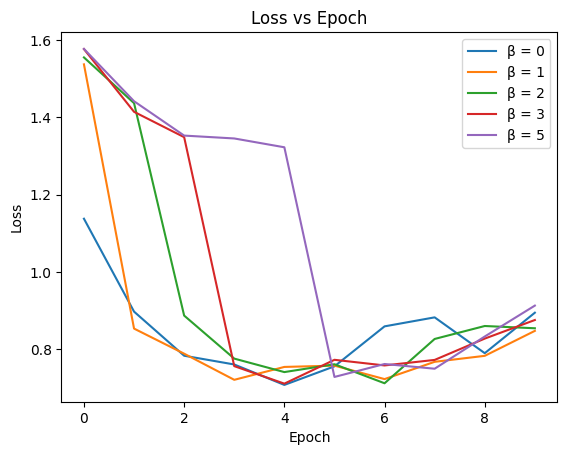

In [8]:
#load loss
train_loss = np.load('cifar10_cnn/loss_1.npy')
val_loss = np.load('cifar10_cnn/val_loss_1.npy')

train_loss2 = np.load('cifar10_cnn/loss_2.npy')
val_loss2 = np.load('cifar10_cnn/val_loss_2.npy')

train_loss3 = np.load('cifar10_cnn/loss_3.npy')
val_loss3 = np.load('cifar10_cnn/val_loss_3.npy')

train_loss4 = np.load('cifar10_cnn/loss_4.npy')
val_loss4 = np.load('cifar10_cnn/val_loss_4.npy')

train_loss5 = np.load('cifar10_cnn/loss_5.npy')
val_loss5 = np.load('cifar10_cnn/val_loss_5.npy')


#plot the loss
#plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='β = 0')
#plt.plot(train_loss2, label='train_loss2')
plt.plot(val_loss2, label='β = 1')
#plt.plot(train_loss3, label='train_loss3')
plt.plot(val_loss3, label='β = 2')
#plt.plot(train_loss4, label='train_loss4')
plt.plot(val_loss4, label='β = 3')
#plt.plot(train_loss5, label='train_loss5')
plt.plot(val_loss5, label='β = 5')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
#plt.savefig('cifar10_cnn/loss.png')
plt.show()

## Plot accuracy

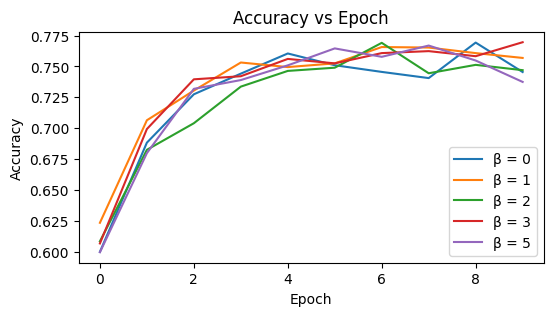

In [4]:
#load the accuracy
acc = np.load('./cifar10_cnn/acc_1.npy')
val_acc = np.load('./cifar10_cnn/val_acc_1.npy')

acc2 = np.load('./cifar10_cnn/acc_2.npy')
val_acc2 = np.load('./cifar10_cnn/val_acc_2.npy')

acc3 = np.load('./cifar10_cnn/acc_3.npy')
val_acc3 = np.load('./cifar10_cnn/val_acc_3.npy')

acc4 = np.load('./cifar10_cnn/acc_4.npy')
val_acc4 = np.load('./cifar10_cnn/val_acc_4.npy')

acc5 = np.load('./cifar10_cnn/acc_5.npy')
val_acc5 = np.load('./cifar10_cnn/val_acc_5.npy')

#plot the accuracy
#plt.plot(acc, label='train_acc')
plt.figure(figsize=(6, 3))
plt.plot(val_acc, label='β = 0')
#plt.plot(acc2, label='train_acc2')
plt.plot(val_acc2, label='β = 1')
#plt.plot(acc3, label='train_acc3')
plt.plot(val_acc3, label='β = 2')
#plt.plot(acc4, label='train_acc4')
plt.plot(val_acc4, label='β = 3')
#plt.plot(acc5, label='train_acc5')
plt.plot(val_acc5, label='β = 5')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
#plt.savefig('cifar10_cnn/acc.png')
plt.show()


In [11]:
#Plot top 3 accuracy
val_top_k_categorical_accuracy = np.load('./cifar10_cnn/val_top_k_categorical_accuracy_1.npy')
val_top_k_categorical_accuracy2 = np.load('./cifar10_cnn/val_top_k_categorical_accuracy_2.npy')
val_top_k_categorical_accuracy3 = np.load('./cifar10_cnn/val_top_k_categorical_accuracy_3.npy')
val_top_k_categorical_accuracy4 = np.load('./cifar10_cnn/val_top_k_categorical_accuracy_4.npy')
val_top_k_categorical_accuracy5 = np.load('./cifar10_cnn/val_top_k_categorical_accuracy_5.npy')

#print optimal accuracies of each model
print('Model 1: β = 0')
print('Train accuracy: ', max(acc))
print('Validation accuracy: ', max(val_acc))
print('Top 3 accuracy: ', max(val_top_k_categorical_accuracy))

print('Model 2 : β = 1')
print('Train accuracy: ', max(acc2))
print('Validation accuracy: ', max(val_acc2))
print('Top 3 accuracy: ', max(val_top_k_categorical_accuracy2))

print('Model 3 : β = 2')
print('Train accuracy: ', max(acc3))
print('Validation accuracy: ', max(val_acc3))
print('Top 3 accuracy: ', max(val_top_k_categorical_accuracy3))

print('Model 4 : β = 3')
print('Train accuracy: ', max(acc4))
print('Validation accuracy: ', max(val_acc4))
print('Top 3 accuracy: ', max(val_top_k_categorical_accuracy4))

print('Model 5 : β = 5')
print('Train accuracy: ', max(acc5))
print('Validation accuracy: ', max(val_acc5))
print('Top 3 accuracy: ', max(val_top_k_categorical_accuracy5))


Model 1: β = 0
Train accuracy:  0.892520010471344
Validation accuracy:  0.7692999839782715
Top 3 accuracy:  0.37459999322891235
Model 2 : β = 1
Train accuracy:  0.8959199786186218
Validation accuracy:  0.7656999826431274
Top 3 accuracy:  0.9415000081062317
Model 3 : β = 2
Train accuracy:  0.8896600008010864
Validation accuracy:  0.76910001039505
Top 3 accuracy:  0.9420999884605408
Model 4 : β = 3
Train accuracy:  0.9027000069618225
Validation accuracy:  0.769599974155426
Top 3 accuracy:  0.9409999847412109
Model 5 : β = 5
Train accuracy:  0.8954799771308899
Validation accuracy:  0.7669000029563904
Top 3 accuracy:  0.9419999718666077


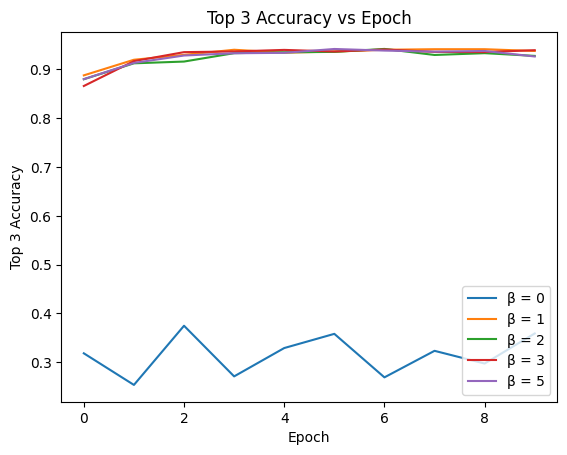

In [12]:


#plot the top 3 accuracy
plt.plot(val_top_k_categorical_accuracy, label='β = 0')
plt.plot(val_top_k_categorical_accuracy2, label='β = 1')
plt.plot(val_top_k_categorical_accuracy3, label='β = 2')
plt.plot(val_top_k_categorical_accuracy4, label='β = 3')
plt.plot(val_top_k_categorical_accuracy5, label='β = 5')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Top 3 Accuracy')
plt.title('Top 3 Accuracy vs Epoch')
plt.savefig('cifar10_cnn/top3_acc.png')
plt.show()



## Save trained model weights

In [13]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar100_cnn_weights.h5')


## Load the trained Model

In [14]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')